In [2]:
import os
import glob
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

## Funções Auxiliares (Carregamento, Salvamento e Visualização)

In [6]:
def desserializar_keypoints(arr: np.ndarray) -> List[cv2.KeyPoint]:
    """
    Reconstrói lista de cv2.KeyPoint a partir do array (N,7).
    """
    kps = []
    for row in arr:
        k = cv2.KeyPoint(
            x=float(row[0]), y=float(row[1]), size=float(row[2]),
            angle=float(row[3]), response=float(row[4]),
            octave=int(row[5]), class_id=int(row[6])
        )
        kps.append(k)
    return kps


def carregar_features_npz(caminho_npz: str) -> Tuple[List[cv2.KeyPoint], np.ndarray, str]:
    """
    Lê um .npz salvo pela Etapa 2 e retorna (keypoints, descriptors, imagem_absoluta).
    """
    with np.load(caminho_npz, allow_pickle=True) as data:
        kps = desserializar_keypoints(data["keypoints"])
        desc = data["descriptors"]
        img_path = str(data["imagem_absoluta"])
    return kps, desc, img_path


def carregar_matches_npz(caminho_npz) -> List[cv2.DMatch]:
    """
    Carrega os matches salvos em .npz e restaura cada linha como um objeto cv2.DMatch.
    Retorna uma lista de cv2.DMatch.
    """

    with np.load(caminho_npz, allow_pickle=True) as data:
        arr = data["matches"]  # array shape (N, 3)
        matches = []
        for row in arr:
            # cv2.DMatch(queryIdx, trainIdx, distance)
            m = cv2.DMatch(_queryIdx=int(row[0]), _trainIdx=int(row[1]), _distance=float(row[2]))
            matches.append(m)
    return matches


def calcular_homogr(kps1, kps2, matches):
    """
    Calcula a homografia entre duas imagens usando os pontos correspondentes.
    """
    if not kps1 or not kps2 or not matches:
        return None

    # Extrai os pontos-chave e descritores
    kps1 = [kps1[m.queryIdx].pt for m in matches]
    kps2 = [kps2[m.trainIdx].pt for m in matches]

    # Calcula a homografia usando RANSAC
    H, status = cv2.findHomography(np.array(kps1), np.array(kps2), cv2.RANSAC)

    return H

def alinhar_imgs(img1, img2, homografia):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Cantos da imagem 2
    cantos2 = np.array([[0,0],[w2,0],[w2,h2],[0,h2]], dtype=np.float32).reshape(-1,1,2)

    # Aplica a homografia nos cantos da imagem 2
    cantos2_trans = cv2.perspectiveTransform(cantos2, homografia)

    # Combina com os cantos da imagem 1 para calcular o retangulo final
    cantos_totais = np.vstack((cantos2_trans, np.array([[0,0],[w1,0],[w1,h1],[0,h1]], dtype=np.float32).reshape(-1,1,2)))
    xmin, ymin = cantos_totais.min(axis=0).ravel().astype(np.int32)
    xmax, ymax = cantos_totais.max(axis=0).ravel().astype(np.int32)

    # Translacao para coordenadas positivas
    translacao = [-xmin, -ymin]
    T = np.array([[1,0,translacao[0]], [0,1,translacao[1]], [0,0,1]])

    # Aplica warpPerspective com a homografia ajustada
    res = cv2.warpPerspective(img2, T @ homografia, (xmax - xmin, ymax - ymin))

    # Coloca img1 na posição correta
    res[translacao[1]:translacao[1]+h1, translacao[0]:translacao[0]+w1] = img1

    return res


## Pipeline Principal da Etapa 4

In [11]:
def analisar_homogr_alinhamento(caminho_base_etapa2: str, caminho_base_etapa3: str, detectores: List[str], matchers: List[str]):
    """
    Pipeline da Etapa 4: Carrega features e matches, calcula homografia com RANSAC e alinha imagens com warpPerspective.
    """
    print(f"\n{'='*65}\nHomografia e alinhamento para o conjunto: '{os.path.basename(caminho_base_etapa3)}'\n{'='*65}")

    # Carrega a ordem das imagens
    caminho_json = os.path.join(caminho_base_etapa2, "ordem_imagens.json")
    try:
        with open(caminho_json, "r") as f:
            arquivos_de_imagem_abs = json.load(f)
    except FileNotFoundError:
        print(f"[Erro] 'ordem_imagens.json' não encontrado em '{caminho_base_etapa2}'. Abortando.")
        return
    
    # Itera sobre os detectores (sift, orb, etc.)
    for nome_detector in detectores:
        print(f"\n--- Detector: {nome_detector.upper()} ---")
        caminho_detector = os.path.join(caminho_base_etapa2, nome_detector)
        arquivos_feature_npz = sorted(glob.glob(os.path.join(caminho_detector, "*_features.npz")))
        if len(arquivos_feature_npz) < 2:
            continue

        # Itera sobre os matchers (bf, flann)
        for nome_matcher in matchers:
            print(f"  - Matcher: {nome_matcher.upper()}")
            caminho_matcher = os.path.join(caminho_base_etapa3, nome_detector, nome_matcher)

            # Cria o diretório de saída para esta combinação
            dir_saida = os.path.join("resultados_etapa4", os.path.basename(caminho_base_etapa3), nome_detector, nome_matcher)
            os.makedirs(dir_saida, exist_ok=True)

            # Itera sobre os pares de imagens
            # Carrega as features da Etapa 2 e matches da Etapa 3
            for i in range(len(arquivos_feature_npz) - 1):
                kps1, desc1, path1 = carregar_features_npz(arquivos_feature_npz[i])
                kps2, desc2, path2 = carregar_features_npz(arquivos_feature_npz[i+1])

                img1 = cv2.imread(path1)
                img2 = cv2.imread(path2)

                match_data = carregar_matches_npz(os.path.join(caminho_matcher, f"matches_{i:03d}_{i+1:03d}.npz"))

                if not kps1 or not kps2 or not match_data:
                    print("[Erro] Não foi possível carregar as features ou matches.")
                    return

                homografia = calcular_homogr(kps1, kps2, match_data)

                if homografia is None:
                    print("[Erro] Não foi possível calcular a homografia.")
                    return

                alinhado = alinhar_imgs(img1, img2, homografia)

                if  alinhado is None:
                    print("[Erro] Não foi possível alinhar as imagens.")
                    return
                
                if i==0 or i == 5: 
                    plt.figure(figsize=(20, 10))
                    plt.imshow(cv2.cvtColor(alinhado, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()


## Execução do Pipeline para os Conjuntos de Imagens


Homografia e alinhamento para o conjunto: 'images-developed-png-16bit'

--- Detector: SIFT ---
  - Matcher: BF


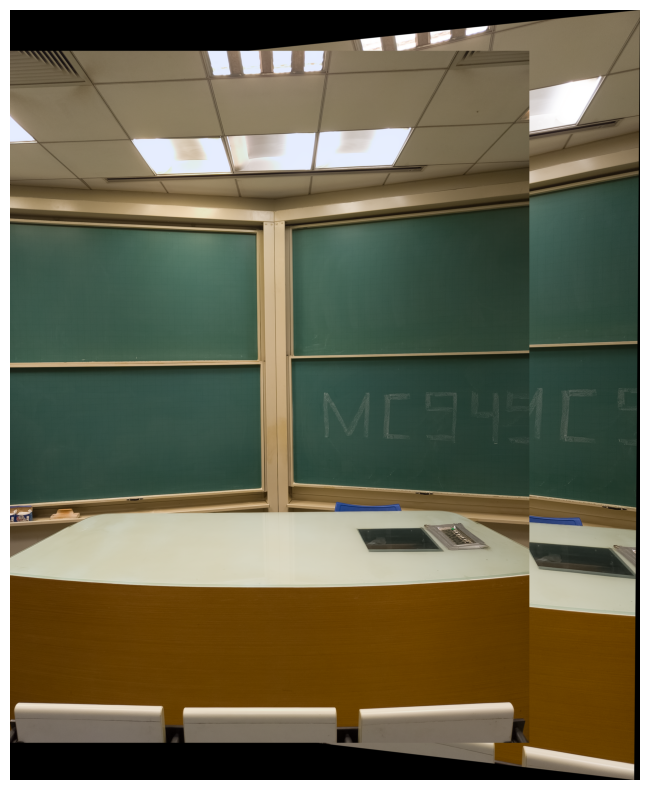

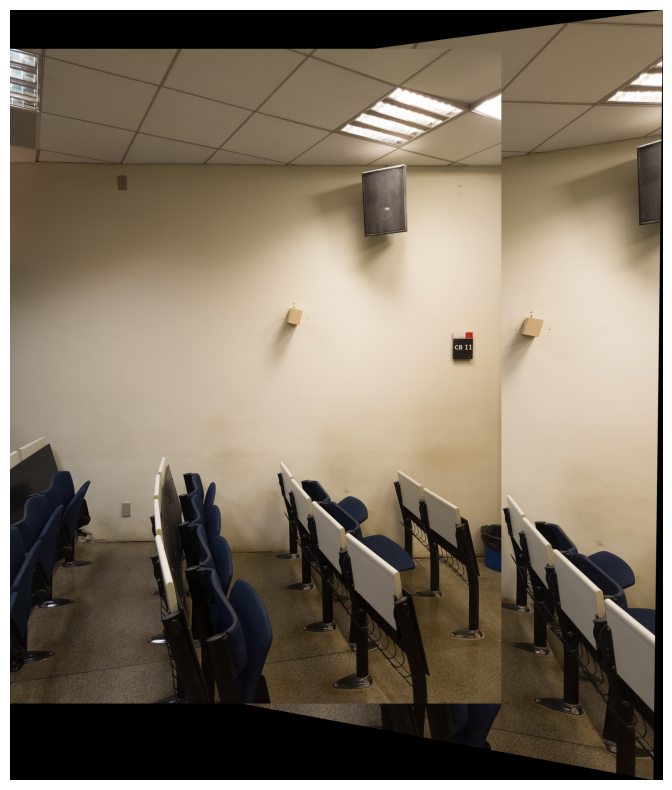

KeyboardInterrupt: 

In [12]:
RAIZ_ETAPA2 = "resultados_etapa2"
RAIZ_ETAPA3 = "resultados_etapa3"
DETECTORS = ['sift', 'orb', 'akaze']
MATCHERS = ['bf', 'flann']

conjuntos = [d for d in os.listdir(RAIZ_ETAPA2) if os.path.isdir(os.path.join(RAIZ_ETAPA2, d))]

for nome_conjunto in sorted(conjuntos):
    caminho_detector = os.path.join(RAIZ_ETAPA2, nome_conjunto)
    caminho_matcher = os.path.join(RAIZ_ETAPA3, nome_conjunto)
    analisar_homogr_alinhamento(caminho_detector, caminho_matcher, DETECTORS, MATCHERS)